In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go
import time
import re
import math
import seaborn as sns

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import heapq
%matplotlib inline

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [2]:
start_time = time.time()
engine = create_engine('sqlite+pysqlite:///../../data/SQL/10C/85_8.db')
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC limit 10000", engine)
end_time = time.time()
print end_time-start_time

engine = create_engine('sqlite+pysqlite:///../../data/SQL/10C/ProtoMap.db')
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
print ProtoMapdf.head()

2.364579916
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4


In [3]:
start_time = time.time()
ADCdf.columns = [np.uint16(_[1:]) if re.match('t\d+',_) is not None else _ for _ in ADCdf.columns ]
ADCdf['max'] = ADCdf.iloc[:,3+50:-50].max(axis=1)
mask= (ADCdf.iloc[:,3:-1]>20) & (ADCdf.iloc[:,3:-1].gt(ADCdf['max']*0.2,axis=0))
ADCdf.iloc[:,3:-1] = ADCdf.iloc[:,3:-1][mask].fillna(0)
end_time = time.time()
print end_time-start_time

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1612: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1592: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



0.479150056839


/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:2393: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



In [4]:
start_time = time.time()
n1 = [_ for _ in ADCdf.columns if type(_) is np.uint16]
n2 = [_ for _ in ADCdf.columns if type(_) is not np.uint16]
t2 = pd.melt(ADCdf.iloc[:],id_vars=n2,value_vars=n1).drop(['ID'],axis=1)
t2.columns = ['EventID','PadNum','max','time','charge']
t3 = pd.merge(t2[t2['charge']>20],ProtoMapdf,on='PadNum')[['EventID','PadNum','time','PadX','PadY','charge']]
print time.time() - start_time

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:2549: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:1211: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



0.770384073257


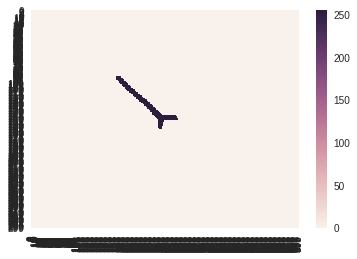

In [5]:
EID= 1
tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)].copy()
p = (tmp['PadNum']-1)%63+1

tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)

Q1 = tmp[(tmp['PadX']>0)&(tmp['PadY']>0)]
Q2 = tmp[(tmp['PadX']<0)&(tmp['PadY']>0)]
Q3 = tmp[(tmp['PadX']<0)&(tmp['PadY']<0)]
Q4 = tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]


image1 = np.zeros([300,600])

image1[(-Q1['PadPos'].values+150).astype(np.int), Q1['time'].values.astype(np.int)] =255
image1[(Q3['PadPos'].values+150).astype(np.int), Q3['time'].values.astype(np.int)] =255

image2 = np.zeros([300,600])

image2[(-Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255
image2[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255

if np.sum(image1-image2)>0:
    image = image1 
else:
    image = image2


########################

gray = cv2.GaussianBlur(image, (3, 3), 0)
ret,im = cv2.threshold(gray.astype(np.uint8), 10, 255, cv2.THRESH_BINARY)

thresh = im.astype(np.uint8)
for _ in range(3):
    thresh = cv2.erode(thresh, None, iterations=1)
    thresh = cv2.dilate(thresh, None, iterations=1)

sns.heatmap(thresh)